# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

- Keuzes en onderbouwing image-datapipepline


## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Fully-connected neuraal netwerk](#Model1)
    - [Convolutioneel neuraal netwerk from scratch](#Model2)
    - [Transfer learning](#Model3)
    - [Multimodaal mode](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [ ]:
!pip install keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from PIL import Image
from sklearn.preprocessing import StandardScaler
from keras_tuner import HyperParameters  as hp
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models

## Data Overview

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data importeren

In [ ]:
train_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/train.csv')
test_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/test.csv')

In [ ]:
img_train_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Train"
img_test_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Test"

## Exploratory Data Analysis

### EDA voor de afbeeldingen


Alle JPEG-afbeeldingen uit de opgegeven map Train en Test worden geladen en opgeslagen in twee lijsten.

In [ ]:
image_paths = tf.io.gfile.glob(img_train_directory + '/*.jpg')
train_images = []
for path in image_paths:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    train_images.append(image)

In [ ]:
image_paths_test = tf.io.gfile.glob(img_test_directory + '/*.jpg')
test_images = []
for path in image_paths_test:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    test_images.append(image)

Het aantal geladen afbeeldingen in de datasets train_images en test_images wordt weergegeven.

In [ ]:
print(f"Aantal geladen afbeeldingen: {len(train_images)}")
print(f"Aantal geladen afbeeldingen: {len(test_images)}")


Aantal geladen afbeeldingen: 500
Aantal geladen afbeeldingen: 35


De vormen (shapes) van de afbeeldingen in de train_images dataset worden geanalyseerd, waarbij alle unieke afbeeldingsformaten worden weergegeven.

In [ ]:
image_shapes = [image.shape for image in train_images]
# Om alle unieke shapes te zien:
print(f"Unique shapes : {set(tuple(shape) for shape in image_shapes)}")

Unique shapes : {(1024, 1024, 3)}


De vorm (shape) van de eerste afbeelding in de train_images dataset wordt hiermee weergegeven.

In [ ]:
print(f"Image shape: {train_images[0].shape}") # geeft de shape van de eerste image (H, W, C)
# het laatste getal in de shape is het aantal kleurkanalen

Image shape: (1024, 1024, 3)


## Voorbeeld van trainings- en testafbeeldingen

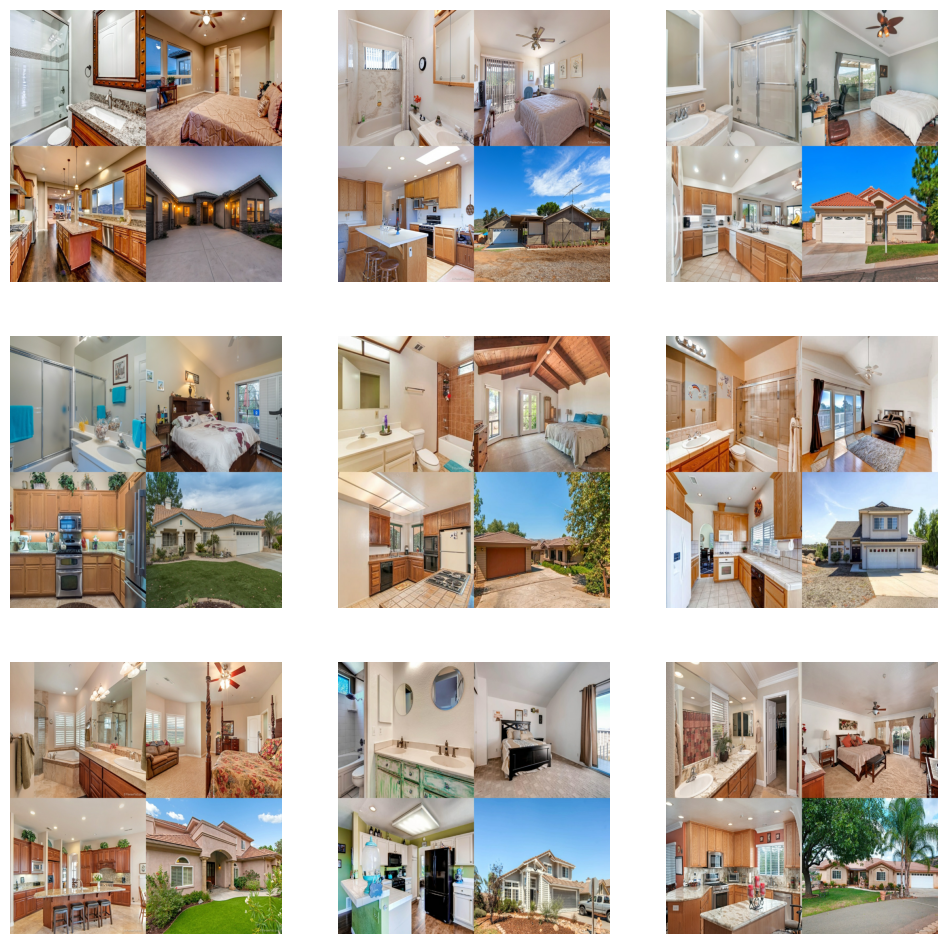

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].numpy())
    plt.axis("off")
plt.show()

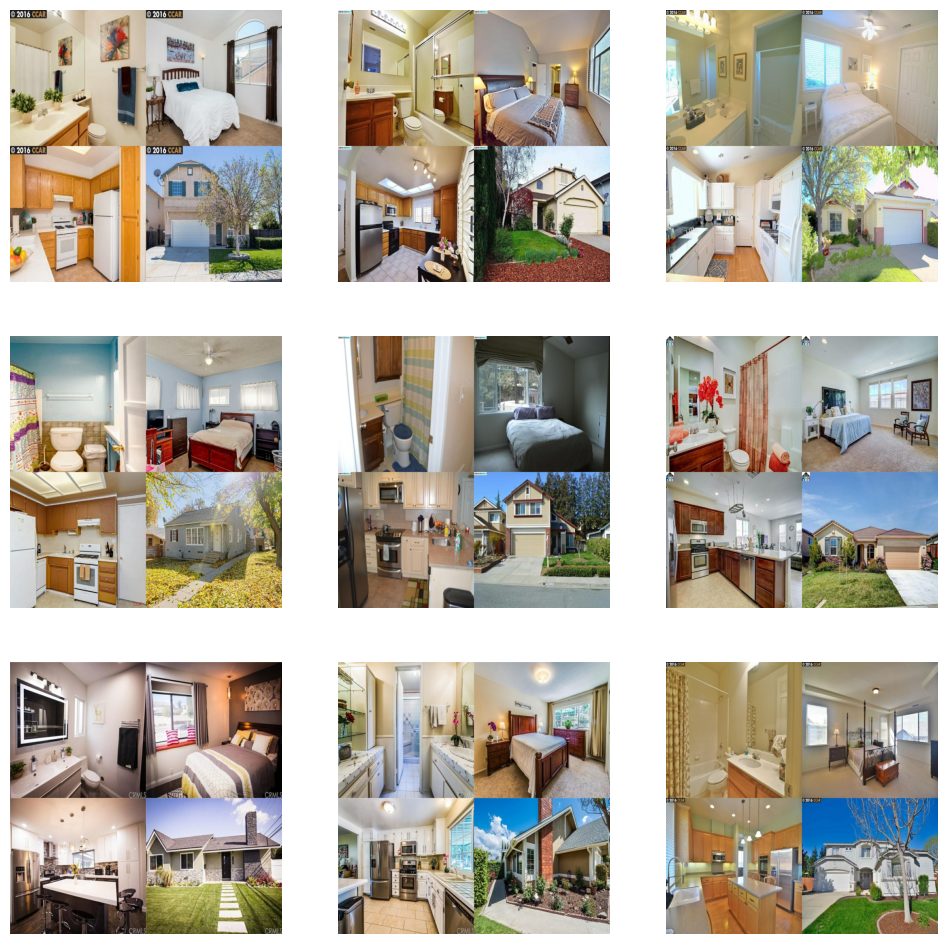

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    plt.axis("off")
plt.show()

De grafiek toont de verdeling van pixelwaarden voor de kleuren rood, groen en blauw in de afbeeldingen.

Mean pixel values: [142.74492561 133.55400624 119.70312065]


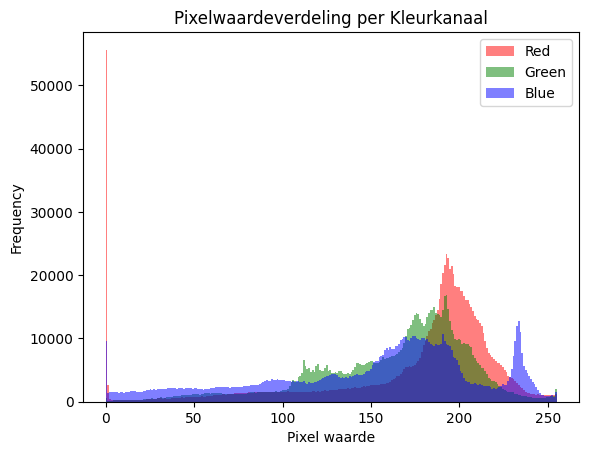

In [ ]:
# Converteer images naar NumPy arrays
image_arrays = [image.numpy() for image in train_images]

# Bereken de gemiddelde pixelwaarde per kanaal
mean_pixel_values = np.mean(image_arrays, axis=(0, 1, 2))
print(f"Mean pixel values: {mean_pixel_values}")

# Plot histogrammen van pixelwaarden per kanaal
plt.hist(image_arrays[0][:, :, 0].flatten(), bins=256, color='red', alpha=0.5, label='Red')
plt.hist(image_arrays[0][:, :, 1].flatten(), bins=256, color='green', alpha=0.5, label='Green')
plt.hist(image_arrays[0][:, :, 2].flatten(), bins=256, color='blue', alpha=0.5, label='Blue')
plt.legend()
plt.title('Pixelwaardeverdeling per Kleurkanaal')
plt.xlabel('Pixel waarde')
plt.ylabel('Frequency')
plt.show()

De x-as vertegenwoordigt de pixelwaarden, die variëren van 0 tot 250, en de y-as geeft het aantal pixels weer voor elke waarde.

Uit de grafiek kunnen we afleiden hoe de intensiteit van elke kleur is verdeeld over de afbeelding. Als een bepaalde kleur een hogere piek heeft bij specifieke pixelwaarden, betekent dit dat die kleurintensiteit vaker voorkomt in de afbeeldingen.

De rode piek is het hoogst, gevolgd door groen en daarna blauw. Dit kan helpen om de kleurbalans en de algemene toon van de afbeelding te begrijpen. Een dominante rode piek kan wijzen op een warmere kleurtemperatuur in de afbeelding
.

### EDA voor tabel data

In [ ]:
display(train_numeriek_df.head())
display(test_numeriek_df.head())

House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price
0         1         4        4.0  4053   33.6968  -111.8892  869500
1         2         4        3.0  3343   34.8280  -119.0349  865200
2         3         3        4.0  3923   33.7669  -111.9182  889000
3         4         5        5.0  4022   33.7752  -111.7791  910000
4         5         3        4.0  4116   33.7669  -111.9182  971226

House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude
0       501         3        2.0  2330   35.6406  -120.7003
1       502         3        2.5  1339   35.6406  -120.7003
2       503         3        2.0  1472   35.6406  -120.7003
3       504         4        4.0  2681   35.6406  -120.7003
4       505         3        2.5  1935   33.8085  -117.9228

###Datatype

In [ ]:
train_numeriek_df.info()
test_numeriek_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


### Kolombeschrijving

**House ID**: Unieke ID voor elk huis (int)  
**Bedrooms**: Het aantal slaapkamers in een huis (int)  
**Bathrooms**: Het aantal badkamers in een huis. Een halve badkamer betekent dan alleen 1 toilet of doucheruimte of wasbak. (float)  
**Area**: Het totale oppervlakte van het huis  
**Latitude**: Coordinaten (float)    
**Latitude**: Coordinaten (float)  
**Price**: De prijs van het huis (int)

### Verdeling van de data

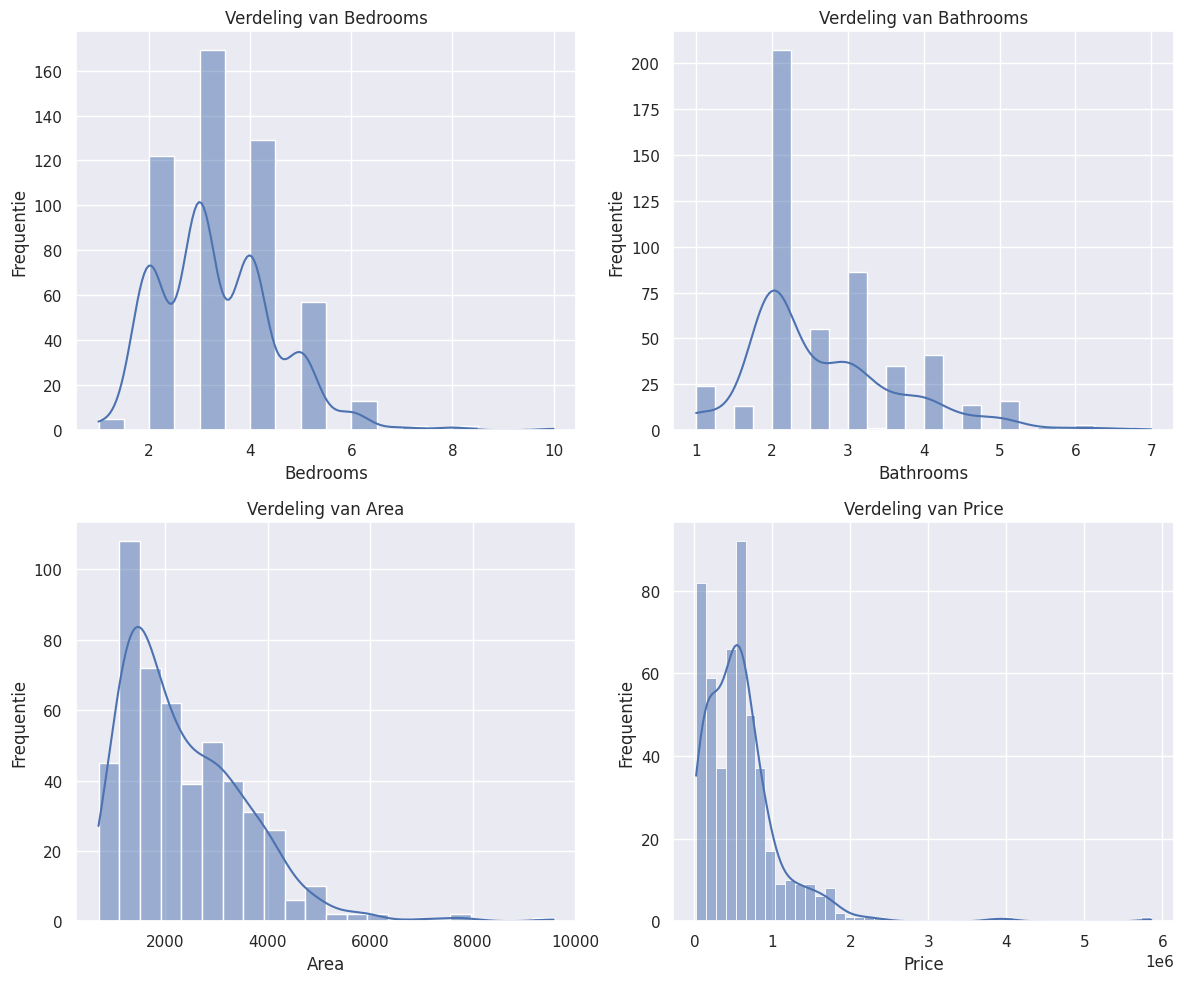

In [ ]:
kolommen = ['Bedrooms', 'Bathrooms', 'Area', 'Price']

sns.set(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogrammen plotten in het raster
ax_index = 0
for rij in range(2):
    for kolom in range(2):
        sns.histplot(train_numeriek_df[kolommen[ax_index]], kde=True, ax=axes[rij, kolom])
        axes[rij, kolom].set_title(f'Verdeling van {kolommen[ax_index]}')
        axes[rij, kolom].set_xlabel(kolommen[ax_index])
        axes[rij, kolom].set_ylabel('Frequentie')
        ax_index += 1

plt.tight_layout()
plt.show()

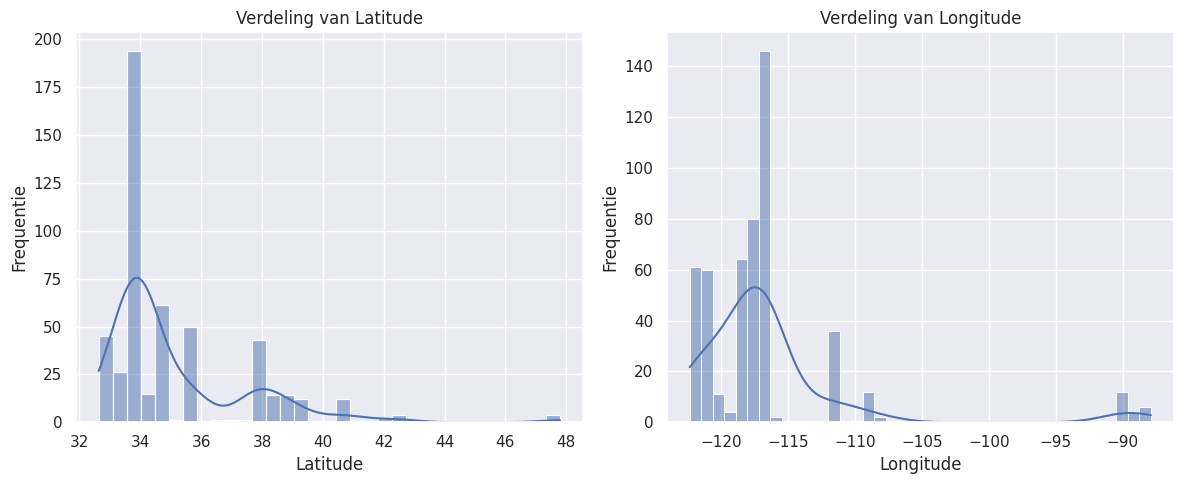

In [ ]:
# Plot histogram voor longtitude en latitude
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogrammen plotten in het raster
ax_index = 0
for kolom in ['Latitude', 'Longitude']:
    sns.histplot(train_numeriek_df[kolom], kde=True, ax=axes[ax_index])
    axes[ax_index].set_title(f'Verdeling van {kolom}')
    axes[ax_index].set_xlabel(kolom)
    axes[ax_index].set_ylabel('Frequentie')
    ax_index += 1

plt.tight_layout()
plt.show()

### Correlaties

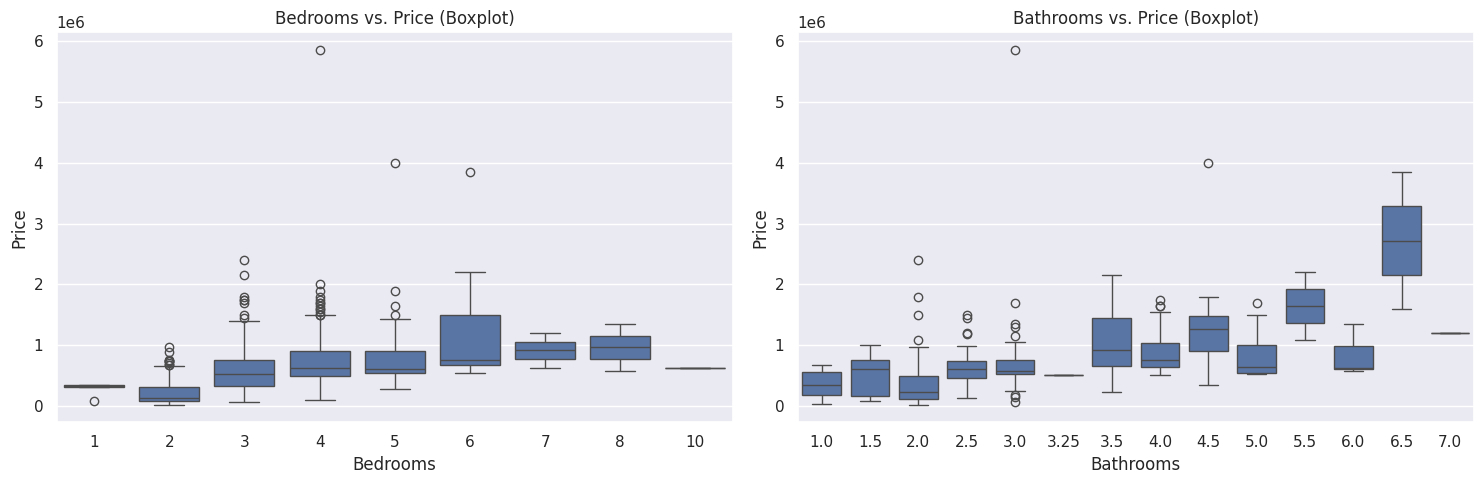

In [ ]:
kolommen = ['Bedrooms', 'Bathrooms']

fig, axes = plt.subplots(1, len(kolommen), figsize=(15, 5))

# Boxplots plotten
for i, kolom in enumerate(kolommen):
    sns.boxplot(x=kolom, y='Price', data=train_numeriek_df, ax=axes[i])
    axes[i].set_title(f'{kolom} vs. Price (Boxplot)')
    axes[i].set_xlabel(kolom)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

#### Bevindingen

**Bedrooms**: Er zit geen sterke lineare verband in deze grafiek. Het blijkt dat huizen met slaapkamers van 1 tot 6 wel een lineare correlatie hebben, maar na 6 slaapkamers verschillen de prijzen niet meer.  
**Bathrooms**: Er blijkt geen lineare verband te zijn in deze grafiek. Maar er is wel te zien dat "halve" badkamers een hogere prijs hebben vergeleken met alleen complete badkamers.  

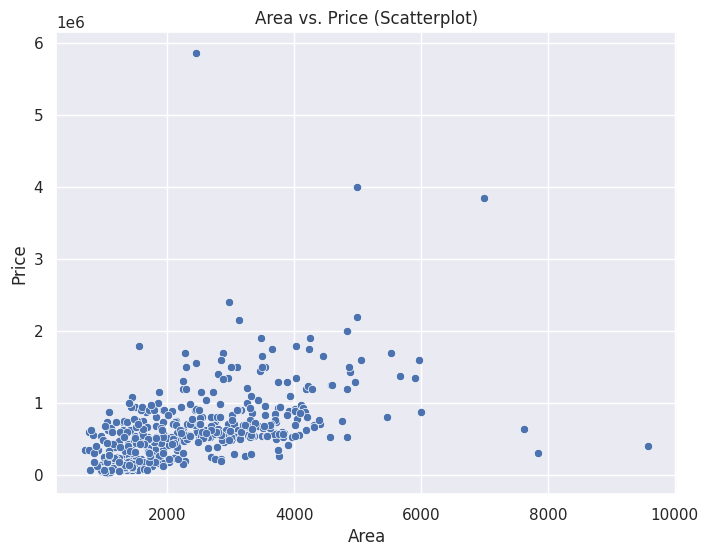

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Area', y='Price', data=train_numeriek_df)
plt.title('Area vs. Price (Scatterplot)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

**Area**: In deze grafiek is er wel een relatief linear verband. Het blijkt dat huizen met een grotere oppervlakte wel duurder zijn.

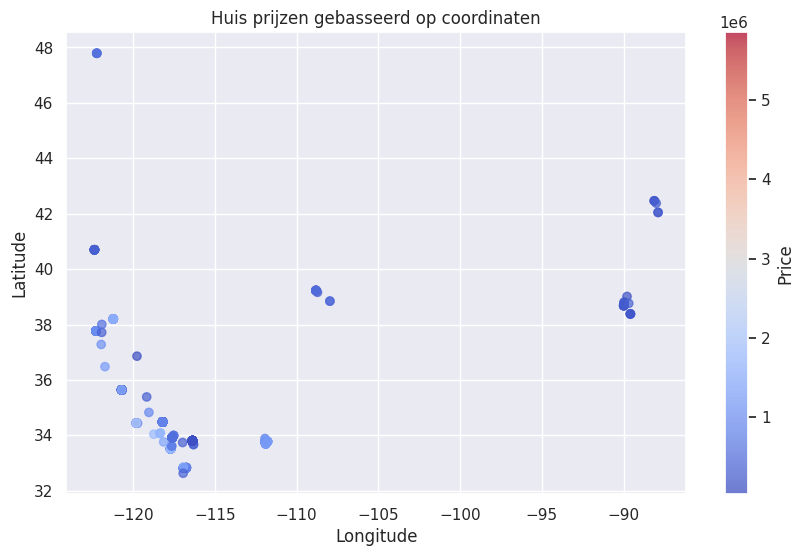

In [ ]:
# Scatterplot maken
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_numeriek_df["Longitude"], train_numeriek_df["Latitude"], c=train_numeriek_df["Price"], cmap="coolwarm", alpha=0.7)

# Kleurbalk toevoegen
plt.colorbar(scatter, label="Price")

# Labels en titel
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Huis prijzen gebasseerd op coordinaten")

# Plot tonen
plt.show()

In deze grafiek worden de prijzen gevisualiseerd op basis van de coordinaten. Er blijkt dat er huizen helemaal links onder aan de duurdere kant liggen.

### Belangrijkste bevindingen
Over het algemeen lijkt woonoppervlakte de sterkste invloed te hebben op de huisprijs, terwijl het effect van slaapkamers en badkamers niet zo duidelijk is. Maar ook de locatie van de huizen blijken een invloed te hebben op de prijs

## Feature Engineering

### Data Preparation

In [ ]:
# Dataloader aanmaken

import tensorflow as tf

def df_to_dataset(dataframe, labels, shuffle=True, batch_size=64):
    '''
    Function to convert a pandas DataFrame into a TensorFlow dataset
    Parameters:
        dataframe (pandas DataFrame): Input features to be converted
        labels (Pandas Series): Input labels to be converted
        shuffle (boolean): Whether to shuffle the dataframe
        batch_size (int): Batch size to use when training
    Returns:
        ds: TensorFlow dataset object
    '''
    df = dataframe.copy()
    df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

### Splitting the data

In [ ]:
X = train_numeriek_df.drop(['Price', 'House ID'], axis=1)
y = train_numeriek_df['Price']

# Get test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
train_ds = df_to_dataset(X_train, y_train, batch_size=32)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=32)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=32)

### Normalize layer

In [ ]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

### Combinatie maken van de Latitude en Longitude
Latitude en Longitude hebben individueel geen relevante informatie. Maar als ze gecombineerd worden, dan kan het heel nuttige informatie geven. In de EDA werd er duidelijk gezien dat in een bepaald gebied de prijs wel duurder is. Dus vandaar dat de coordinaten ook relevant kunnen zijn.

In [ ]:
def get_bucketization_layer(name, dataset, num_bins=10):
    # Create a Bucketization layer for the feature.
    bucketizer = layers.Discretization(num_bins=num_bins)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    bucketizer.adapt(feature_ds)

    return bucketizer

def get_feature_crossing_layer(feature1, feature2, num_bins=100):
    # Create HashedCrossing() layer
    cross = layers.HashedCrossing(num_bins=num_bins)

    # Cross the two features using this layer
    feature_cross = cross([feature1, feature2])

    #  Convert this tensor to the same type as the numeric tensors, float32 in this case. Use tf.cast()
    # feature_cross = layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32))(feature_cross)

    return feature_cross

### Data Transforming

De tabulair data wordt eerst genormaliseerd met de boven gedefineerde functie. Daarna worden er bucket locations aangemaakt. Deze bucket locations representeren een bepaald area van de coordinaten. Alle inputs worden dan later samengevoegd met de Functional API

In [ ]:
# Create a list to store the raw data inputs
all_inputs = []

# Create a list to store the bucketized latitude and longitude
bucketized_locations = []

# Create a list to store the engineered features
engineered_features = []

# Standardize numerical features
for header in ['Bedrooms', 'Bathrooms', 'Area']:

    # Create input layer with shape (1,) and name=header
    numeric_col = keras.Input(shape=(1,), name=header)

    # Call normalization function with the correct arguments
    normalization_layer = get_normalization_layer(name=header, dataset=train_ds)

    # Apply the layer on the input column
    encoded_numeric_col = normalization_layer(numeric_col)

    # Append input column to list of inputs
    all_inputs.append(numeric_col)

    # Append engineered feature to list of engineered features
    engineered_features.append(encoded_numeric_col)

# Bucketize location features
for header in ['Latitude', 'Longitude']:

    # Create input layer with shape (1,) and name=header
    location_col = keras.Input(shape=(1,), name=header)

    # Call bucketization function with the correct arguments
    bucketization_layer = get_bucketization_layer(name=header, dataset=train_ds, num_bins=2)

    # Apply the layer on the input column
    bucketized_col = bucketization_layer(location_col)

    # Append input column to list of inputs
    all_inputs.append(location_col)

    # Append engineered feature to list of bucketized locations
    bucketized_locations.append(bucketized_col)

# Cross the bucketized latitude with bucketized longitude
crossed_location_feature = get_feature_crossing_layer(bucketized_locations[0], bucketized_locations[1], num_bins=4)
engineered_features.append(crossed_location_feature)

# Merge the list of engineered features into one vector via concatentation with tf.keras.layers.concatenate
all_features = tf.keras.layers.concatenate(engineered_features)

### Image transformation

In [ ]:
# Wijzig de vorm van alle afbeeldingen na de lus
resized_train_images = []
for image in train_images:
    resized_image = tf.image.resize(image, (224, 224))  # Wijzig de gewenste vorm
    resized_train_images.append(resized_image)

## Modeling

### Fully-connected neuraal netwerk

Een Fully Connected layer, ook bekend als een Dense layer, is een essentieel onderdeel van neurale netwerken. Elke neuron in een layer is verbonden met alle neuronen in de vorige en volgende laag, waardoor een sterk geïntegreerd netwerk ontstaat.

#### Structuur

Een fully connected layer bevat de volgende componenten:
- **Neuronen**: Eenheden die input ontvangen van alle neuronen in de vorige laag en verder wordt verwerkt in de volgende laag.
- **Gewichten (Weights)**: Elk neuron heeft een gewicht dat bepaalt hoe sterk de input wordt beïnvloed.
- **Biases**: Een extra parameter die helpt de output te optimaliseren.
- **Activatiefuncties**: Niet-lineaire functies (zoals ReLU, Sigmoid of Tanh) worden toegepast om het netwerk complexe patronen te laten leren. Dit zorgt ervoor dat de uitkomst niet linear is

#### Werking
1. Input verwerking  
Elke neuron berekent een gewogen som van de inputs plus een bias:  
$$ z_j = \sum_{i} (w_{ij} \cdot x_i) + b_j $$

  Waarbij:  
    $w_{ij}$ = gewicht van neuron $i$ naar neuron $j$  
    $x_i$ = inputwaarde van neuron $i$  
    $b_j$ = bias van neuron $j$      


2. Toepassing van activatiefunctie  
Vervolgens wordt een activatiefunctie {f} toegepast, zoals ReLU, Sigmoid of Tanh:  
$$ a_j = f(z_j) $$

[(GeeksforGeeks. (2024, May 27))](https://www.geeksforgeeks.org/what-is-fully-connected-layer-in-deep-learning/?ref=ml_lbp
)



Voor deze model is er gekozen voor 3 layer, omdat we niet zo een grote dataset hebben. Meer layers kan voor overfitten zorgen. Verder zitten er 128 neuronen in de eerste laag, 64 in de 2e laag en 32 in de laatste laag. Ook hier is er gekozen voor minder neuronen vanwege de kleine dataset. Voor regularisatie is er gekozen Dropout en L1. Dropout zorgt ervoor dat bepaalde neuronen uitvallen tijdens het trainen, dit kan overfitten voorkomen. Daarnaast zorgt L1 ervoor om de gewichten te dwingen naar 0, zodat minder belangrijke features wegvallen. Dit voorkomt ook overfitting.  [(Olamendy, 2024)](https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50)

De optimizer voor deze model is Adam. Adam is een combinatie van momentum, adaptive learning rate en batches training. Dit maakt het geschikt voor complexe datasets.  [(GeeksforGeeks. (2025, March 4))](https://www.geeksforgeeks.org/adam-optimizer/)

De gekozen aantal epochs is 150. De reden hiervoor is omdat het model lang genoeg getrained kan worden indien het later pas iets leert tijdens het trainen. Maar ook is er een callback function gemaakt die ervoor zorgt dat het model stopt met trainen indien er geen verschil meer is in de loss.

De loss functie die hiervoor gekozen is, is de MAPE (Mean Absolute Percentage Error). De reden hiervoor is omdat de voorspelde waarde prijzen zijn, waardoor de waardes continue maar ook heel groot zijn.

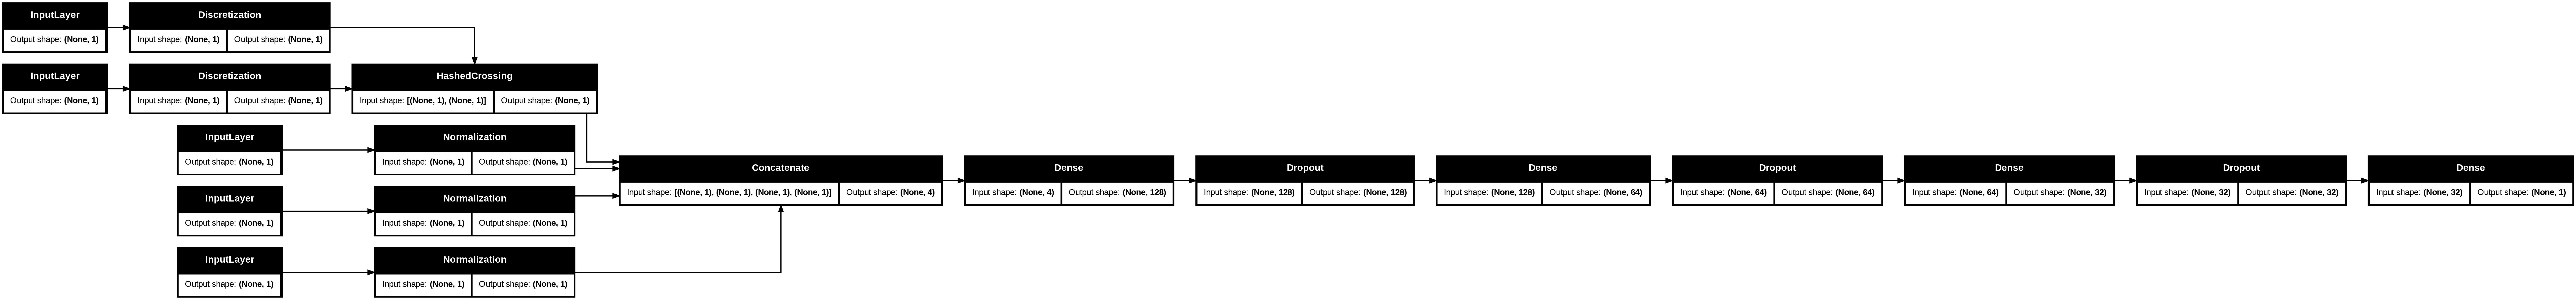

In [ ]:
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.01))(all_features)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1)(x)

model_eng = Model(inputs=all_inputs, outputs=output)

model_eng.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mse','mape'])

plot_model(model_eng, show_shapes=True, rankdir="LR")

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_eng.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1, epochs=150, callbacks=[early_stopping])

# Evaluate
loss, mse, mape = model_eng.evaluate(test_ds)
print("MSE: ", mse)
print("MAPE: ", mape)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 100.4661 - mape: 99.9999 - mse: 571657879552.0000 - val_loss: 100.2644 - val_mape: 99.9990 - val_mse: 1329779572736.0000
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 100.2150 - mape: 99.9983 - mse: 597085585408.0000 - val_loss: 100.0902 - val_mape: 99.9937 - val_mse: 1329760698368.0000
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 100.0635 - mape: 99.9898 - mse: 510525669376.0000 - val_loss: 99.9896 - val_mape: 99.9630 - val_mse: 1329648369664.0000
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 99.9646 - mape: 99.9405 - mse: 517796593664.0000 - val_loss: 99.8419 - val_mape: 99.8264 - val_mse: 1329155801088.0000
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 99.7599 - mape: 99.7448 - mse: 529793613824.0000 - val_loss: 99.4020 - val_mape: 99.3866 - val_mse: 1327561965568.0000
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 99.2028 - mape: 99.1792 - mse: 582745784

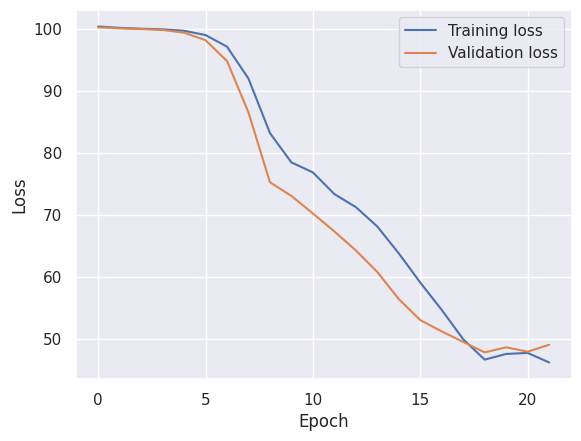

In [ ]:
# Plot de loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Hypertuning

In [ ]:
def build_model(hp):
    """Builds a Keras model with tunable hyperparameters."""

    # Define input layers as before
    all_inputs = []
    engineered_features = []
    bucketized_locations = []

    # ... (your existing code to create input layers and features)
        # Create a list to store the raw data inputs
    all_inputs = []

    # Create a list to store the bucketized latitude and longitude
    bucketized_locations = []

    # Create a list to store the engineered features
    engineered_features = []

    # Standardize numerical features
    for header in ['Bedrooms', 'Bathrooms', 'Area']:

        # Create input layer with shape (1,) and name=header
        numeric_col = keras.Input(shape=(1,), name=header)

        # Call normalization function with the correct arguments
        normalization_layer = get_normalization_layer(name=header, dataset=train_ds)

        # Apply the layer on the input column
        encoded_numeric_col = normalization_layer(numeric_col)

        # Append input column to list of inputs
        all_inputs.append(numeric_col)

        # Append engineered feature to list of engineered features
        engineered_features.append(encoded_numeric_col)

    # Bucketize location features
    for header in ['Latitude', 'Longitude']:

        # Create input layer with shape (1,) and name=header
        location_col = keras.Input(shape=(1,), name=header)

        # Call bucketization function with the correct arguments
        bucketization_layer = get_bucketization_layer(name=header, dataset=train_ds, num_bins=2)

        # Apply the layer on the input column
        bucketized_col = bucketization_layer(location_col)

        # Append input column to list of inputs
        all_inputs.append(location_col)

        # Append engineered feature to list of bucketized locations
        bucketized_locations.append(bucketized_col)

    # Cross the bucketized latitude with bucketized longitude
    crossed_location_feature = get_feature_crossing_layer(bucketized_locations[0], bucketized_locations[1], num_bins=4)
    engineered_features.append(crossed_location_feature)

    # Merge the list of engineered features into one vector via concatentation with tf.keras.layers.concatenate
    all_features = tf.keras.layers.concatenate(engineered_features)

    # Tune the number of units in the first Dense layer
    hp_units1 = hp.Int('units1', min_value=16, max_value=128, step=32)
    x = layers.Dense(units=hp_units1, activation="relu", kernel_regularizer=regularizers.l1(0.01))(all_features)
    x = layers.Dropout(0.3)(x)

    # Tune the number of units in the second Dense layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=128, step=32)
    x = layers.Dense(units=hp_units2, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    # Tune the number of units in the thirds Dense layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=128, step=32)
    x = layers.Dense(units=hp_units2, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1)(x)

    model = Model(inputs=all_inputs, outputs=output)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.005])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mape',
                  metrics=['mape'])

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='intro_to_kt_2')

tuner.search_space_summary()

tuner.search(train_ds,
             epochs=150,
             validation_data=val_ds,
             callbacks=[early_stopping])

Trial 10 Complete [00h 00m 23s]
val_mape: 45.18277359008789

Best val_mape So Far: 45.08280690511068
Total elapsed time: 00h 03m 53s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mape = best_model.evaluate(test_ds)
print("MAPE: ", mape)
print(best_model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 40.7589 - mape: 40.3681 
MAPE:  41.24991226196289


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Latitude (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Longitude (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bedrooms (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bathrooms (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ discretization            │ (None, 1)              │              0 │ Latitude[0][0]         │
│ (Discretization)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ discretization_1          │ (None, 1)              │              0 │ Longitude[0][0]        │
│ (Discretization)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 1)              │              3 │ Bedrooms[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 1)              │              3 │ Bathrooms[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 1)              │              3 │ Area[0][0]             │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hashed_crossing           │ (None, 1)              │              0 │ discretization[0][0],  │
│ (HashedCrossing)          │                        │                │ discretization_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4)              │              0 │ normalization[0][0],   │
│                           │                        │                │ normalization_1[0][0], │
│                           │                        │                │ normalization_2[0][0], │
│                           │                        │                │ hashed_crossing[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │             80 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 112)            │          1,904 │ dropout[0][0]          │
├──────────────────────

 Total params: 14,762 (57.68 KB)

 Trainable params: 14,753 (57.63 KB)

 Non-trainable params: 9 (48.00 B)

None


#### Beste parameters

Beste hyperparameters na de hyperparameter tuning:

- 1e Dense layer: 16 neuronen
- 2e Dense Layer: 112 neuronen
- 2e Dense Layer: 112 neuronen  

Kaggle score: 0.6

### Convolutioneel neuraal netwerk from scratch

Een Convolutioneel Neuraal Netwerk (CNN) is een speciaal type neuraal netwerk dat vooral wordt gebruikt voor het verwerken van afbeeldingen. CNN's zijn goed in taken zoals het herkennen van objecten en het classificeren van beelden. Ze werken door patronen in een afbeelding te zoeken met behulp van wiskundige berekeningen, zoals convoluties. Hierdoor kunnen ze vormen, randen en structuren herkennen, wat belangrijk is voor computer vision-toepassingen zoals gezichtsherkenning en zelfrijdende auto's.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


#### Basisprincipes van CNN's


##### 1. Convolutie Laag (Convolution Layer)


De convolutielaag is een belangrijk onderdeel van een CNN. Het gebruikt een klein filter (ook wel kernel genoemd) om een afbeelding te analyseren en belangrijke kenmerken te herkennen.

- Filter: Een klein raster (bijvoorbeeld 3×3) dat over de afbeelding beweegt.

- Stapgrootte (Stride): Het aantal pixels dat het filter per keer opschuift.

- Padding: Extra pixels aan de randen van de afbeelding toevoegen om de afmetingen van de uitvoer te behouden.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/
)


**Berekening:** Op elke positie wordt het filter vermenigvuldigd met het bijbehorende deel van de afbeelding. Daarna worden de resultaten opgeteld om een nieuw beeld te vormen.

##### 2. Pooling Laag (Pooling Layer)

Pooling is een techniek die helpt om de hoeveelheid gegevens in een afbeelding te verkleinen. Dit maakt het model sneller en minder gevoelig voor kleine veranderingen in de afbeelding.

- Max Pooling: Kiest de hoogste waarde in een klein gebied van de afbeelding.

- Average Pooling: Berekent het gemiddelde van de waarden in een klein gebied.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

##### 3. Activatiefunctie (Activation Function)

Een activatiefunctie zorgt ervoor dat een neuraal netwerk complexe patronen kan leren door niet-lineariteit toe te voegen. Een veelgebruikte activatiefunctie is ReLU (Rectified Linear Unit), die negatieve waarden naar nul omzet en positieve waarden doorlaat.


[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/)


##### 4. Fully Connected Layer (Volledig verbonden laag)

Deze laag zorgt voor de classificatie op basis van de kenmerken die in de vorige lagen zijn gevonden. Terwijl convolutie- en poolinglagen vaak de ReLU-activeringsfunctie gebruiken, maakt de volledig verbonden laag (fully connected layer) gebruik van de Softmax-functie. Deze functie zet de uitkomsten om in waarschijnlijkheden tussen 0 en 1, zodat het netwerk kan voorspellen tot welke klasse een invoer behoort.


[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


[(IBM. (z.d.))](https://www.ibm.com/think/topics/convolutional-neural-networks)

#### Regularisatie in Convolutionele Neurale Netwerken


**L1-regularisatie (Lasso):** Hierbij wordt de absolute waarde van de gewichten opgeteld bij de verliesfunctie. Dit zorgt ervoor dat sommige gewichten precies nul worden, waardoor minder belangrijke parameters verdwijnen. Het resultaat is een eenvoudiger model met minder filters.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum |β_i|
$$

**L2-regularisatie (Ridge, Weight Decay):** Deze methode telt de kwadraten van de gewichten op bij de verliesfunctie. Hierdoor blijven de gewichten klein en worden extreme waarden voorkomen. Dit helpt het model stabieler en minder gevoelig voor overfitting te maken.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum β_i^2
$$


[(Tewari, 2024)](https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf)



**Dropout** is een techniek om overfitting te voorkomen in diepe neurale netwerken. Tijdens het trainen worden willekeurig sommige uitgangen van een laag genegeerd ("dropout"). Hierdoor leert het model minder afhankelijk te zijn van specifieke neuronen en wordt het robuuster.

[(GeeksforGeeks, 2024a)](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/
)


Batch normalisatie zorgt ervoor dat een CNN sneller en stabieler traint door de activaties per batch te normaliseren. Dit voorkomt dat waarden te groot of te klein worden en helpt het netwerk beter om te gaan met variaties in de invoerdata. Hierdoor kan het model efficiënter leren.



[(Wikipedia contributors, 2024b)](https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.)

Data-augmentatie is een manier om overfitting te verminderen bij CNN’s. Door de trainingsdata te variëren met technieken zoals roteren, schalen, spiegelen en vervormen, leert het model robuustere en algemenere kenmerken. Dit helpt het netwerk beter om te gaan met nieuwe, onbekende afbeeldingen.

[(IBM. (z.d.))](https://www.ibm.com/think/topics/data-augmentation)


#### Hoe kies je de beste regularisatie?

De keuze voor regularisatie hangt af van het doel van je model. L1-regularisatie is handig als je een eenvoudiger model met minder parameters wilt, terwijl L2-regularisatie beter is als je alle features wilt behouden maar hun invloed wilt beperken. Data-augmentatie is vooral nuttig bij beeldherkenning en deep learning, omdat het variatie in de trainingsdata toevoegt en zo de generalisatie verbetert. Dropout werkt goed in diepe neurale netwerken, vooral bij grote modellen, omdat het willekeurig neuronen uitschakelt tijdens training en zo overfitting tegengaat.

[(Olamendy, 2024)](https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50)

Een kolom 'filename' wordt toegevoegd aan de DataFrame train_numeriek_df, waarin het bestandspad van elke afbeelding wordt gegenereerd op basis van de 'House ID'.

In [ ]:
# Genereert een nieuwe kolom 'filename'
train_numeriek_df['filename'] = train_numeriek_df['House ID'].apply(lambda x: f"{img_train_directory}/{x}.jpg")

# Controleer of de bestanden bestaan
invalid_files = []
for file_path in train_numeriek_df['filename']:
    if not os.path.exists(file_path):
        invalid_files.append(file_path)

if invalid_files:
    print(f"Aantal ongeldige bestanden: {len(invalid_files)}")
    print("Voorbeelden van ongeldige bestanden:", invalid_files[:5])
else:
    print("Alle bestanden zijn geldig.")


Alle bestanden zijn geldig.


De dataset train_numeriek_df wordt opgesplitst in een trainingset (80%) en een validatieset (20%), waarbij random_state=42 zorgt voor reproduceerbaarheid.

In [ ]:
# Split in train/validation
train_df = train_numeriek_df.sample(frac=0.8, random_state=42)
val_df = train_numeriek_df.drop(train_df.index)


De prijzen in zowel de trainings- als validatieset worden genormaliseerd door elke waarde te delen door de maximale prijs in de dataset.

In [ ]:
train_df['Price'] = train_df['Price'] / train_df['Price'].max()
val_df['Price'] = val_df['Price'] / val_df['Price'].max()

**Keuzes en onderbouwing image-datapipepline**

In de trainingspipeline (train_datagen) worden de beelden geschaald en op verschillende manieren aangepast. Dit gebeurt met rotaties, verschuivingen, horizontale en verticale flips, helderheidsveranderingen en zoom. Deze augmentatie zorgt ervoor dat het model beter leert van variatie in de beelden en voorkomt overfitting. Alle beelden worden ook genormaliseerd naar waarden tussen 0 en 1 met rescale=1./255.

De validatiepipeline (val_datagen) gebruikt alleen rescale=1./255 om de beelden te schalen. Er wordt hier geen augmentatie toegepast, zodat het model wordt geëvalueerd op originele, niet-aangepaste beelden. Zo krijgen we een eerlijk beeld van de prestaties van het model.

Met flow_from_dataframe worden twee generators aangemaakt: één voor training (train_generator) en één voor validatie (validation_generator). Beide laden de beelden op basis van bestandsnamen en geven de bijbehorende prijs als label (class_mode='raw'). De beelden worden aangepast naar een vaste grootte van 256x256 pixels. Tijdens training worden de batches geschud (shuffle=True) om overfitting te verminderen. Bij validatie is shuffle=False, zodat de volgorde hetzelfde blijft voor een betrouwbare evaluatie.

In [ ]:
# Data augmentation voor training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2
)

# Alleen rescaling voor validatie
val_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=True  # ✅ Zorg dat de batches worden geschud
)

# Validation generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=False  #
)


Found 400 validated image filenames.
Found 100 validated image filenames.


In [ ]:
# Definieer het CNN-model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout voor regularisatie
    Dense(1)  # Output laag voor regressie
])

# Compileer het model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mape',
              metrics=['mape'])

# Early Stopping om overfitting te voorkomen
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Samenvatting van het model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train het model
history = model.fit(
    train_generator,
    epochs=10,  # Aantal epochs, kan aangepast worden
    validation_data=validation_generator,
    callbacks=[early_stopping],  # Gebruik EarlyStopping om overfitting te voorkomen
    verbose=1
)

# Evalueer het model op de validatiedata
loss, mape = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation MAPE: {mape}")

# Voorspel de waarden voor de validatiedata
y_pred = model.predict(validation_generator)
y_true = validation_generator.labels

# Bereken MAPE handmatig
mape = np.mean(np.abs((y_true - y_pred.flatten()) / y_true)) * 100
print(f"Validation MAPE: {mape:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 1867.5514 - mape: 1866.3591 - val_loss: 88.9937 - val_mape: 87.7755
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 75.6446 - mape: 74.3792 - val_loss: 83.9066 - val_mape: 82.5556
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 69.8139 - mape: 68.4520 - val_loss: 84.5740 - val_mape: 83.1881
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 69.4861 - mape: 68.0983 - val_loss: 88.3859 - val_mape: 86.9967
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 72.5553 - mape: 71.1669 - val_loss: 80.7920 - val_mape: 79.4074
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 68.3615 - mape: 66.9788 - val_loss: 84.8367 - val_mape: 83.4596
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 69.9987 - mape: 68.6236 - val_loss: 86.3540 - val_mape: 84.9852
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 69.8379 - mape: 68.4712 - val_loss: 80.5086 - val_mape: 79.1480
Epoch 9/10
13/13 ━━━

#### Hypertuning


In [ ]:
def build_cnn_model(hp):
    model = Sequential()

    # Tune number of filters in each Conv2D layer
    for i in range(4):
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', values=[32, 64, 128, 256]),
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=l2(0.001),
            input_shape=(256, 256, 3) if i == 0 else None
        ))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Tune number of units in Dense layer
    hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
    model.add(Dense(hp_units, activation='relu', kernel_regularizer=l2(0.001)))

    # Tune dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))

    model.add(Dense(1))  # Output layer for regression

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mape',
                  metrics=['mape'])

    return model

# Define Keras Tuner search
cnn_tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=2,
    directory='cnn_tuner_dir',
    project_name='cnn_hyper_tuning_2'
)

# Perform hyperparameter tuning
cnn_tuner.search(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Retrieve best model
best_cnn_model = cnn_tuner.get_best_models(num_models=1)[0]
loss, mape = best_cnn_model.evaluate(validation_generator)
print(f"Best CNN Validation Loss: {loss}")
print(f"Best CNN Validation MAPE: {mape}")

# Predict and calculate MAPE
y_pred = best_cnn_model.predict(validation_generator)
y_true = validation_generator.labels
mape = np.mean(np.abs((y_true - y_pred.flatten()) / y_true)) * 100
print(f"Best CNN Validation MAPE: {mape:.2f}%")

Trial 3 Complete [00h 05m 14s]
val_loss: 74.35950088500977

Best val_loss So Far: 73.78038787841797
Total elapsed time: 00h 15m 09s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 76.7812 - mape: 75.9496
Best CNN Validation Loss: 73.59964752197266
Best CNN Validation MAPE: 72.76806640625
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step
Best CNN Validation MAPE: 72.77%


In [ ]:
best_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │          73,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,277,281 (8.69 MB)

 Trainable params: 2,277,281 (8.69 MB)

 Non-trainable params: 0 (0.00 B)

#### Beste parameters
Beste parameters na hypertuning:
- Layer 1: 256 neuronen
- Layer 1: 128 neuronen
- Layer 1: 256 neuronen
- Layer 1: 32 neuronen
- Layer 1: 256 neuronen

### Transfer learning

Transfer learning is een machine learning-techniek waarbij een model dat eerder is getraind op een specifieke taak, wordt hergebruikt als basis voor een tweede, gerelateerde taak. Dit is vooral nuttig wanneer er beperkte data beschikbaar is voor de nieuwe taak, omdat het model al algemene kenmerken heeft geleerd die toepasbaar zijn op meerdere taken. Doordat het model tijdens de initiële training kennis heeft opgedaan uit een grote dataset, kan het sneller en efficiënter worden aangepast aan de nieuwe taak
[(GeeksforGeeks. (z.d.))](https://www.geeksforgeeks.org/ml-introduction-to-transfer-learning/)


#### Modelkeuze en Pretraining
Voor deze opdracht hebben wij gebruik gemaakt van ResNet50 als vooraf getraind computervisiemodel. Dit model is vooraf getraind op de ImageNet-dataset, een grootschalige dataset met miljoenen afbeeldingen verspreid over 1000 klassen.

Voordelen van vooraf getrainde visionmodellen:
- Snellere convergentie: Omdat het model al patronen heeft geleerd uit een grote dataset, is er minder trainingstijd nodig.
- Betere generalisatie: Het model heeft al veelvoorkomende kenmerken zoals randen, texturen en objectvormen geleerd.
- Minder data nodig: Transfer learning werkt goed met kleinere datasets, omdat het model al goede feature-extracties kan uitvoeren.
- Efficiënt gebruik van rekenkracht: Het hergebruiken van een bestaand model bespaart computationele kosten vergeleken met het trainen van een model vanaf nul.

#### Modelarchitectuur en Visualisatie
Voor het bouwen van het model hebben wij de volgende stappen doorlopen:

Data Augmentatie:

- RandomFlip: Willekeurige horizontale spiegeling om variatie in de dataset te vergroten.

- RandomRotation (0.2): Willekeurige rotatie om het model robuuster te maken.
- RandomZoom (0.2): Willekeurige in- of uitzooming om variatie in de dataset te vergroten.
- RandomBrightness (0.2): Willekeurige aanpassing van de helderheid om het model robuuster te maken.

Preprocessing:

- Lambda Layer om de afbeeldingen te preprocessen met de ImageNet normalisatie.

Gebruik van ResNet50 als basis:

- Input shape: (224, 224, 3)

- Base model zonder top layers (feature-extractor modus).

- Bevroren gewichten in de beginfase om eerdere kennis te behouden.

Custom Layers toegevoegd voor fine-tuning:

- GlobalAveragePooling2D(): Reduceert de feature map tot een enkele vector.

- Dense(512, relu) + Dropout(0.3): Voegt non-lineariteit en voorkomt overfitting.

- Dense(128, relu) + Dropout(0.2): Extra non-lineariteit en regularisatie.

- Dense(1): Uitgangslaag voor regressie


[(TensorFlow. (n.d.))](https://www.tensorflow.org/tutorials/images/transfer_learning)_

[(Keras. (n.d.). ResNet50 model)](https://keras.io/api/applications/resnet/#resnet50-function)

In [ ]:
# Convert to numpy arrays
X_images = np.array(resized_train_images)
y_prices = train_numeriek_df['Price'].values

# Create TensorFlow Dataset

def create_dataset(images, prices, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, prices))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Split into train/validation (80/20)
split = int(0.8 * len(X_images))
train_ds = create_dataset(X_images[:split], y_prices[:split])
val_ds = create_dataset(X_images[split:], y_prices[split:])

In [ ]:

#  Model Construction
base_model = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

preprocess_input = tf.keras.applications.resnet50.preprocess_input

model = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Light data augmentation
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),

     # Preprocessing
    layers.Lambda(preprocess_input),

    # Base model
    base_model,

    # Feature extraction
    layers.GlobalAveragePooling2D(),

    # Regression head
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1),  # Single output for regression
])

# . Model Compilation
base_learning_rate = 0.0005
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='mape',  # Mean Squared Error for regression
    metrics=['mape']  # Mean Absolute Error & Percentage Error
)

# . Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# . Model Training
initial_epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stopping]
)





# Unfreeze de laatste lagen van ResNet50
base_model.trainable = True
for layer in base_model.layers[:80]:
    layer.trainable = False

# Recompile met een nog lagere learning rate
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=base_learning_rate/100),
    loss='mape',
    metrics=['mape']
)

# Fine-tune training met verhoogde dropout en L2 regularisatie
model.pop()  # Verwijder de laatste Dense laag
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.3))  # Dropout verhoogd
model.add(layers.Dense(1))

# Train opnieuw met fine-tuning
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping]
)




Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - loss: 99.9965 - mape: 99.9965 - val_loss: 99.9712 - val_mape: 99.9712
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 99.9632 - mape: 99.9632 - val_loss: 99.8763 - val_mape: 99.8763
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 99.8715 - mape: 99.8715 - val_loss: 99.6529 - val_mape: 99.6529
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 99.6678 - mape: 99.6678 - val_loss: 99.2163 - val_mape: 99.2163
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 99.2958 - mape: 99.2958 - val_loss: 98.4746 - val_mape: 98.4746
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 98.6325 - mape: 98.6325 - val_loss: 97.3112 - val_mape: 97.3112
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 97.6484 - mape: 97.6484 - val_loss: 95.6138 - val_mape: 95.6138
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 96.2775 - mape: 96.2775 - val_loss: 93.2595 - val_mape: 93.2595
Epoch 9

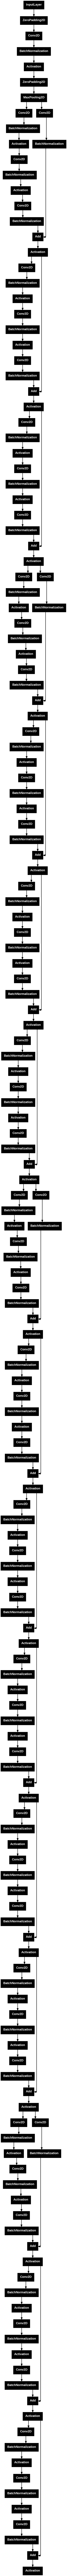

In [ ]:
plot_model(base_model)

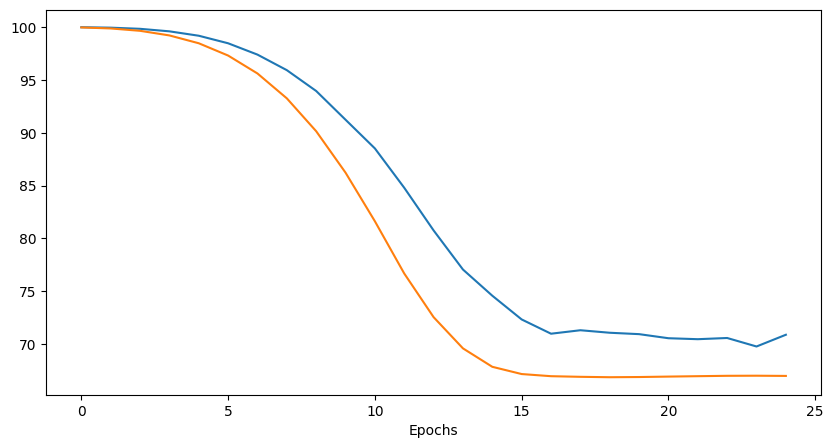

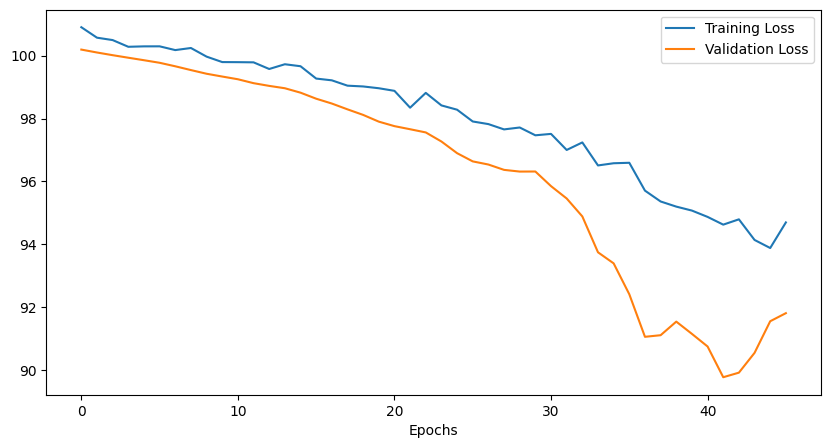

In [ ]:
#plot the loss curves off history and history_fine


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')

plt.figure(figsize=(10, 5))
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')

plt.legend()
plt.show()



#### Hypertuning

In [ ]:
# Base Model
def build_model(hp):
    # Define the ResNet50 base model
    base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                                include_top=False,
                                                input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model initially

    preprocess_input = tf.keras.applications.resnet50.preprocess_input

    # Create the model
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        # Light data augmentation
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2),

        # Preprocessing layer
        layers.Lambda(preprocess_input),

        # Base model
        base_model,

        # Feature extraction
        layers.GlobalAveragePooling2D(),

        # First dense layer (hyperparameterized)
        layers.Dense(units=hp.Int('units_1', min_value=16, max_value=512, step=32)),
        layers.Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),

        # Second dense layer (hyperparameterized)
        layers.Dense(units=hp.Int('units_2', min_value=16, max_value=512, step=32)),
        layers.Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.1)),

        # Third dense layer (hyperparameterized)
        layers.Dense(units=hp.Int('units_3', min_value=16, max_value=512, step=32)),
        layers.Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.4, step=0.1)),

        # Output layer
        layers.Dense(1)
    ])

    # Unfreeze the last layers of ResNet50
    base_model.trainable = True
    for layer in base_model.layers[:80]:
        layer.trainable = False


    # Compile the model with hyperparameter-based optimizer
    model.compile(
        optimizer='adam',
        loss='mape',
        metrics=['mape']
    )

    return model

# RandomSearch Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=4,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='resnet50_regression_with_mape_3'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_mape', patience=6, restore_best_weights=True)

# Hyperparameter Search
tuner.search(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best Hyperparameters: {best_hps.values}")

# Rebuild the model with the best hyperparameters
best_model = build_model(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])


Trial 4 Complete [00h 03m 50s]
val_loss: 75.16865539550781

Best val_loss So Far: 75.16865539550781
Total elapsed time: 00h 13m 34s
Best Hyperparameters: {'units_1': 48, 'dropout_1': 0.2, 'units_2': 240, 'dropout_2': 0.2, 'units_3': 240, 'dropout_3': 0.4}
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 836ms/step - loss: 99.9790 - mape: 99.9790 - val_loss: 99.3432 - val_mape: 99.3432
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - loss: 99.1674 - mape: 99.1674 - val_loss: 81.8095 - val_mape: 81.8095
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - loss: 92.6788 - mape: 92.6788 - val_loss: 69.2763 - val_mape: 69.2763
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 78.5791 - mape: 78.5791 - val_loss: 87.5133 - val_mape: 87.5133
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 69.2480 - mape: 69.2480 - val_loss: 49385.1016 - val_mape: 49385.1016
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - loss: 73.7637 - mape: 73.7637 - val_loss: 104551.2500 - val_map

#### Beste parameters  
Beste parameters na hypertuning:  
- Layer 1: 48 neuronen  
- Dropout 1: 0.2  
- Layer 2: 240 neuronen  
- Dropout 2: 0.2  
- Layer 3: 240 neuronen  
- Dropout 3: 0.4  

### Multimodaal mode

Een multimodaal model is een geavanceerd neuraal netwerk dat informatie uit verschillende modaliteiten (type data), zoals tekst, beeld en audio, combineert.
Hierdoor kan het model een rijkere en meer contextuele representatie van de data ontwikkelen.

#### Structuur

Een multimodaal model bevat de volgende componenten:

- **Modale sub-netwerken**: Gespecialiseerde netwerken die kenmerken uit een specifieke modaliteit extraheren, bijvoorbeeld een Convolutional Neural Network (CNN) voor beeld of een Transformer voor tekst.

- **Fusion layer**: Een integratielaag die de verkregen kenmerken van de verschillende modaliteiten samenvoegt tot één gezamenlijke representatie.

- **Cross-modale interacties**: Mechanismen die de relaties tussen de verschillende modaliteiten modelleren, waardoor de context en samenhang tussen de datastromen beter wordt benut.


#### Werking

1. **Input verwerking**  
   Elke modaliteit wordt afzonderlijk verwerkt door een speciaal sub-netwerk, dat de relevante kenmerken extraheert:  
   $$ \textbf{z}^{(mod)} = f_{mod}(\textbf{x}^{(mod)}) $$  
   Waarbij:  
   - \( f_{mod} \) de functie is die de kenmerken uit de inputmodaliteit \( \textbf{x}^{(mod)} \) extraheert.

2. **Fusion van modaliteiten**  
   De afzonderlijk verkregen representaties worden gecombineerd in een fusion layer, zodat de complementariteit tussen de modaliteiten benut kan worden:  
   $$ \textbf{z}_{fusion} = g(\textbf{z}^{(1)}, \textbf{z}^{(2)}, \dots, \textbf{z}^{(n)}) $$  
   Hierbij beschrijft \( g \) de fusie-operatie (zoals concatenatie, optelling of een complex cross-attention mechanisme).

3. **Taak-specifieke verwerking**  
   De gecombineerde representatie \( \textbf{z}_{fusion} \) wordt gebruikt voor de uiteindelijke voorspelling of taak, zoals classificatie of regressie. Hierdoor kan het model op basis van de geïntegreerde informatie nauwkeurigere resultaten leveren.


### Redenering achter het gekozen model

Gezien de dataset slechts 500 afbeeldingen en 500 rijen bevat, is het van groot belang om het model niet te complex te maken.
De keuzes voor het aantal lagen en neuronen zijn dan gericht op het voorkomen van overfitting en het behouden van een generalisatie.

- **Aantal lagen:**  
  - **Tabulaire data:** Er worden twee Dense-lagen gebruikt (32 en 16 neuronen). Dit is voldoende om relevante patronen te leren zonder te veel parameters te introduceren, wat bij een kleine dataset snel kan leiden tot overfitting.
  - **Afbeeldingsdata:** Zowel voor de RGB als de grijswaardenpaden zijn twee Conv2D-lagen aangehouden. Extra lagen zouden de complexiteit onnodig verhogen en zoals gezien na het uploaden van onze resultaten, de score verlagen.

- **Selectie van neuronen per laag:**  
  - In de tabulaire tak zorgen 32 en 16 neuronen voor een balans tussen complexiteit en generalisatie. Met hoger aantal neuronen hebben wij gezien, dat ons model veel slechter performeert. (124, 256 en zelfs 512 uitgeprobeerd)
  - Bij de afbeeldingspaden beginnen we met 16 filters in de eerste Conv2D-laag, waarna dit wordt opgeschaald naar 32 filters. Deze waarden zijn standaard en effectief gebleken voor kleine tot middelgrote datasets.  
  - De Dense-laag na het flattenen bevat 64 neuronen, wat de belangrijkste visuele features goed kan vastleggen zonder de kans op overfitting te vergroten.

- **Regularisatie en optimalisatie:**  
  - L2 regularisatie in de convolutionele lagen en een early stopping callback zorgen ervoor dat het model stopt met trainen zodra de verbetering stagneert. Dit helpt om te voorkomen dat het model te veel gaat 'leren' uit de beperkte data.
  - De keuze voor de Adam optimizer met een redelijke learning rate (0.001) draagt bij aan een stabiele en efficiënte training, zelfs met een kleine dataset.

- **Guidelines uit de praktijk:**  
  Volgens praktijktips van experts is het vaak aan te raden om te starten met een eenvoudige architectuur.
  Bijvoorbeeld, in artikel "A Recipe for Training Neural Networks" op karpathy is geschreven hoe een kleiner netwerk vaak betere resultaten kan opleveren bij beperkte data, omdat dit de kans op overfitting verkleint. Dit is wat wij ook hebben gemerkt in onze model


[GeeksforGeeks. (2024, July 5)](https://www.geeksforgeeks.org/multimodal-ai/?ref=header_outind)

[(A Recipe for Training Neural Networks. (2019, April 25). )](https://karpathy.github.io/2019/04/25/recipe/)

In [ ]:
multimodaal_train_df = train_numeriek_df.copy()

df = train_numeriek_df.copy()

# Images omzetten naar arrays
def load_image_as_array(house_id, img_directory, target_size=(64, 64), mode='RGB'):
    """
    Loads an image for the given house_id from img_directory,
    converts it to the specified mode, and resizes it.
    """
    image_path = os.path.join(img_directory, f"{house_id}.jpg")
    if os.path.exists(image_path):
        image = Image.open(image_path).convert(mode)
        image = image.resize(target_size)
        image_array = np.array(image)
        # For grayscale images, add a channel dimension
        if mode == 'L':
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    else:
        return None

num_features = ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']

df = multimodaal_train_df.copy()

# Normalize target variable
df['Price'] = df['Price'] / df['Price'].max()

# NormalizeStandardScaler
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Voor elke image rgb en grayscale
df['Image_RGB'] = df['House ID'].apply(lambda x: load_image_as_array(x, img_train_directory, target_size=(64,64), mode='RGB'))
df['Image_Gray'] = df['House ID'].apply(lambda x: load_image_as_array(x, img_train_directory, target_size=(64,64), mode='L'))

# Drop rows if images are missing
df = df.dropna(subset=['Image_RGB', 'Image_Gray'])


train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# For images normalize pixels to [0,1]
X_train_rgb = np.array(train_df['Image_RGB'].tolist()).astype('float32') / 255.0
X_train_gray = np.array(train_df['Image_Gray'].tolist()).astype('float32') / 255.0
X_train_tabular = train_df[num_features].values

X_val_rgb = np.array(val_df['Image_RGB'].tolist()).astype('float32') / 255.0
X_val_gray = np.array(val_df['Image_Gray'].tolist()).astype('float32') / 255.0
X_val_tabular = val_df[num_features].values

y_train = train_df['Price'].values
y_val = val_df['Price'].values


# 1. Tabular
tabular_input = Input(shape=(len(num_features),), name="tabular_input")
t = Dense(16, activation='relu')(tabular_input)
t = Dense(32, activation='relu')(t)

# 2. RGB Image
rgb_input = Input(shape=(64, 64, 3), name="rgb_input")
r = Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(rgb_input)
r = MaxPooling2D((2, 2))(r)
r = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(r)
r = MaxPooling2D((2, 2))(r)
r = Flatten()(r)
r = Dense(64, activation='relu')(r)

# 3. Grayscale
gray_input = Input(shape=(64, 64, 1), name="gray_input")
g = Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(gray_input)
g = MaxPooling2D((2, 2))(g)
g = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(g)
g = MaxPooling2D((2, 2))(g)
g = Flatten()(g)
g = Dense(64, activation='relu')(g)

# Combine models
combined = Concatenate()([t, r, g])
z = Dense(32, activation='relu')(combined)
z = Dense(32, activation='relu')(z)
output = Dense(1, activation='linear', name="output")(z)

model = Model(inputs=[tabular_input, rgb_input, gray_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mape')

# Visualize the model architecture
model.summary()
plot_model(model, to_file='multimodal_model.png', show_shapes=True, show_layer_names=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    [X_train_tabular, X_train_rgb, X_train_gray], y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_tabular, X_val_rgb, X_val_gray], y_val),
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rgb_input (InputLayer)    │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gray_input (InputLayer)   │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 62, 62, 16)     │            448 │ rgb_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 62, 62, 16)     │            160 │ gray_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 31, 31, 16)     │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 31, 31, 16)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 29, 29, 32)     │          4,640 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 29, 29, 32)     │          4,640 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tabular_input             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 14, 14, 32)     │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 14, 14, 32)     │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 16)             │             96 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 6272)           │              0 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 6272)           │              0 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 32)             │            544 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 64)             │        401,472 │ flatten_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 64)             │        401,472 │ flatten_7[0][0]        │
├──────────────────────

 Total params: 819,713 (3.13 MB)

 Trainable params: 819,713 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - loss: 285.1799 - val_loss: 92.7634
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 54.9751 - val_loss: 65.5602
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 52.9302 - val_loss: 49.0505
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 58.2852 - val_loss: 56.5587
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 42.9447 - val_loss: 66.1747
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 44.1555 - val_loss: 47.2807
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 40.4843 - val_loss: 45.7592
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 37.0322 - val_loss: 49.7916
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 36.5714 - val_loss: 46.8090
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 33.4139 - val_loss: 50.3947
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 30.5838 - val_loss: 39.5583
Epoch 12/100
13/13 ━━━━━━━━━

Text(0.5, 0, 'Epochs')

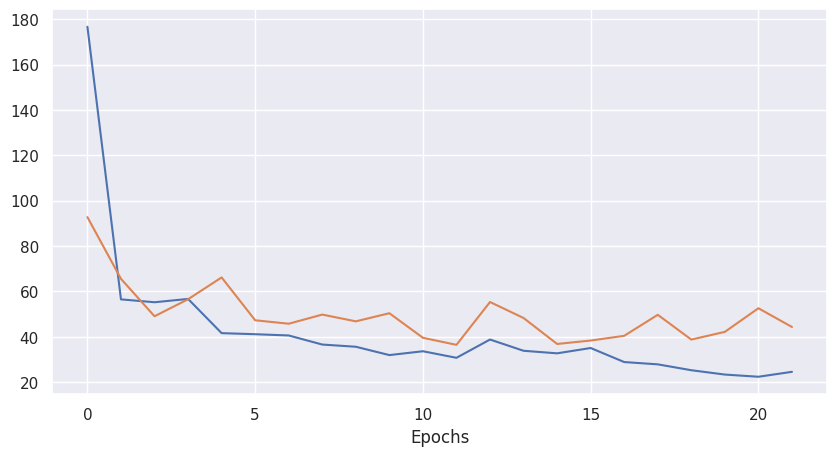

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')

### Hypertuning

In [ ]:
def build_model(hp):
    # Tabular input
    tabular_input = Input(shape=(len(num_features),), name="tabular_input")
    t = Dense(hp.Int('dense_units_t', min_value=16, max_value=128, step=16), activation='relu')(tabular_input)
    t = Dense(hp.Int('dense_units_t2', min_value=16, max_value=128, step=16), activation='relu')(t)

    # RGB Image input
    rgb_input = Input(shape=(64, 64, 3), name="rgb_input")
    r = Conv2D(hp.Int('filters_r1', min_value=16, max_value=64, step=16), (3, 3), activation='relu')(rgb_input)
    r = MaxPooling2D((2, 2))(r)
    r = Conv2D(hp.Int('filters_r2', min_value=32, max_value=128, step=32), (3, 3), activation='relu')(r)
    r = MaxPooling2D((2, 2))(r)
    r = Flatten()(r)
    r = Dense(hp.Int('dense_units_r', min_value=32, max_value=128, step=32), activation='relu')(r)

    # Grayscale input
    gray_input = Input(shape=(64, 64, 1), name="gray_input")
    g = Conv2D(hp.Int('filters_g1', min_value=16, max_value=64, step=16), (3, 3), activation='relu')(gray_input)
    g = MaxPooling2D((2, 2))(g)
    g = Conv2D(hp.Int('filters_g2', min_value=32, max_value=128, step=32), (3, 3), activation='relu')(g)
    g = MaxPooling2D((2, 2))(g)
    g = Flatten()(g)
    g = Dense(hp.Int('dense_units_g', min_value=32, max_value=128, step=32), activation='relu')(g)

    # Combine models
    combined = Concatenate()([t, r, g])
    z = Dense(hp.Int('dense_units_final', min_value=32, max_value=128, step=32), activation='relu')(combined)
    z = Dense(hp.Int('dense_units_final2', min_value=16, max_value=64, step=16), activation='relu')(z)

    output = Dense(1, activation='linear', name="output")(z)

    model = Model(inputs=[tabular_input, rgb_input, gray_input], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='mape'
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Aantal willekeurige combinaties die getest worden
    executions_per_trial=2,  # Hoe vaak elk model wordt geëvalueerd
    directory='random_search_1',
    project_name='tabular_rgb_gray_model_1'
)


tuner.search(
    x=[X_train_tabular, X_train_rgb, X_train_gray],
    y=y_train,
    epochs=50,
    validation_data=([X_val_tabular, X_val_rgb, X_val_gray], y_val),
    batch_size=32, callbacks=[early_stopping]
)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Beste configuratie: {best_hps.values}")

Trial 10 Complete [00h 00m 40s]
val_loss: 31.13397789001465

Best val_loss So Far: 30.561057090759277
Total elapsed time: 00h 06m 59s
Beste configuratie: {'dense_units_t': 80, 'dense_units_t2': 128, 'filters_r1': 64, 'filters_r2': 128, 'dense_units_r': 128, 'filters_g1': 32, 'filters_g2': 96, 'dense_units_g': 96, 'dense_units_final': 96, 'dense_units_final2': 32, 'learning_rate': 0.001}


#### Beste parameters
Beste parameters na hypertuning:
- Layer 1: 80 neuronen
- Layer 2: 128 neuronen
- Layer 3: 64 neuronen
- Layer 4: 128 neuronen
- Layer 5: 128 neuronen
- Layer 6: 32 neuronen
- Layer 7: 96 neuronen
- Layer 8: 96 neuronen
- Layer 9: 32 neuronen
- Learning rate: 0.001


## Results

### Overview

### Scores

|Model|Notebook|Kaggle|
|----|------|------|
|Dense network|0.42|0.48|
|CNN|0.72|0.64|
|Transfer learning|0.75|0.92|
|Multimodaal|0.3|0.4|

## Conclusion & Advice

Het blijkt dat de beste model de Multimodaal netwerk is, met een Kaggle score van 0.4. Aangezien deze model een combinatie is van de tabular en image data, kan deze model heel goed zijn in deze soort regressie problemen. De hypertuning heeft niet specifiek voor een beter score gezorgd, dus de initiele parameters werd wel goed ingeschat. Ook is voor deze model geen bucketization gebruikt omdat we eerder zagen dat het niet een betere score opleverde vergeleken met wanneer er wel de rauwe Longitude en Latitude werd gebruikt. Dit kan zijn omdat de dataset niet zo groot is om bucketization toe te passen.

De beste (initiele) waardes waren:
- Layer 1: 16 neuronen
- Layer 2: 32 neuronen
- Layer 3: 16 neuronen
- Layer 4: 32 neuronen
- Layer 5: 64 neuronen
- Layer 6: 16 neuronen
- Layer 7: 32 neuronen
- Layer 8: 32 neuronen
- Layer 9: 32 neuronen
- Learning rate: 0.001


Voor elk model werden er technieken gebruikt om de regularisatie en parameters te bepalen. De uitdagingen hiervan waren om het model te laten leren, want soms bleef de loss op dezelfde waardes of heel hoog. Dit konden we zien aan de hand van de loss curves in het grafiek. Dat betekende dus dat het model niets leerde. Dus aan de hand hiervan werden er aanpassingen gemaakt aan het model. Een ander uitdaging was ook de hypertuning. Deze proces duurde heel lang, dus hebben we ervoor gekozen voor de randomsearch die minder lang duurt. Maar toch bleek het niet de scores te verbeteren. Het beste methode was toch om in te schatten wat de juiste input waardes waren voor de hyperparameters en parameters. De reden hiervoor is omdat de dataset niet zo groot is, maar ook omdat we de dataset begrepen en hoe onze voorspellingen eruit moesten zien. Hierdoor konden wij de juiste regularisatie toepassen en de nodige layers.

#### Advies
Als wij terug gaan naar de EDA, hebben wij als advies voor de makelaar dat de huizen die aan de linkeronderkant van de map zijn, veel winst kunnen leveren aangezien hun hoge prijzen. Hierdoor kan de makelaar makkelijk hoge commissie verdienen. Maar ook huizen die een extra toilet of wasbak hebben, kunnen ook duurder zijn dan alleen 1 complete badkamer.


Voor potentiele huizenkopers die op een budget zijn, hebben wij als advies om niet in die omgeving een huis te zoeken, maar liever in het midden of rechterkant van de map.





In [ ]:
import numpy as np
import pandas as pd

def submission(pred, test_df, filename):
    """
    Creates a submission file for a prediction.

    Args:
        pred (np.ndarray): The predictions.
        test_df (pd.DataFrame): The test dataframe.
        filename (str): The filename of the submission file (must include .csv extension).

    Returns:
        pd.DataFrame: The submission dataframe.
    """
    # Ensure pred is a 1D array and has the same length as test_df
    pred = pred.reshape(-1)  # Flatten if necessary
    pred = pred[:len(test_df)]  # Truncate to match test_df length

    # Create the submission DataFrame
    df = pd.DataFrame({'House ID': test_df['House ID'], 'Price': pred})

    # Save the DataFrame to a CSV file
    df_n = df.to_csv(filename, index=False)

    # Return the DataFrame (optional)
    return df_n

## Sources

- Torres, L. F. (2023, 23 november). Convolutional Neural Network From Scratch - LatinXInAI - Medium. Medium. https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07

- GeeksforGeeks. (2024b, oktober 10). Introduction to Convolution Neural Network. GeeksforGeeks. https://www.geeksforgeeks.org/introduction-convolution-neural-network/

- IBM. (z.d.). Convolutional neural networks. IBM. https://www.ibm.com/think/topics/convolutional-neural-networks

- Tewari, U. (2024, 19 januari). Regularization — Understanding L1 and L2 regularization for Deep Learning. Medium. https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf

- GeeksforGeeks. (2024a, maart 26). Dropout regularization in deep learning. GeeksforGeeks. https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

- Wikipedia contributors. (2024b, december 25). Batch normalization. Wikipedia. https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.

- Olamendy, J. C. (2024, 28 november). A Comprehensive Guide to Regularization in Machine Learning. Medium. https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50

- IBM. (z.d.). Data augmentation. https://www.ibm.com/think/topics/data-augmentation

- GeeksforGeeks. (2024, May 27). What is Fully Connected Layer in Deep Learning? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-fully-connected-layer-in-deep-learning/?ref=ml_lbp

- GeeksforGeeks. (2025, March 4). What is Adam Optimizer? GeeksforGeeks. https://www.geeksforgeeks.org/adam-optimizer/

- GeeksforGeeks. (2024, July 5). Multimodal Learning in Artificial Intelligence (AI). GeeksforGeeks. https://www.geeksforgeeks.org/multimodal-ai/?ref=header_outind

- A Recipe for Training Neural Networks. (2019, April 25). https://karpathy.github.io/2019/04/25/recipe/

- TensorFlow. (n.d.). Transfer learning with tf.keras. TensorFlow. Geraadpleegd op 26 maart 2025, van https://www.tensorflow.org/tutorials/images/transfer_learning

- Keras. (n.d.). ResNet50 model. Keras. Geraadpleegd op 26 maart 2025, van https://keras.io/api/applications/resnet/#resnet50-function
- GeeksforGeeks. (z.d.). ML | Introduction to Transfer Learning. GeeksforGeeks. https://www.geeksforgeeks.org/ml-introduction-to-transfer-learning/
- Multimodal Learning in Artificial Intelligence (AI). GeeksforGeeks. https://www.geeksforgeeks.org/multimodal-ai/?ref=header_outind

In [ ]:
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>